**2021-12-09:** updated from Knut's CrowdingColor.ipynb notebook to read in the augmented joint-LF file **jointlf_gi_wVecs.fits** with the mag vectors packaged in the metadata. Also now takes the filter labels from the metadata.

Also now includes interpolation along a locus in (mag0, mag1) space.

In [1]:
import numpy as np
from scipy.interpolate import interp1d,griddata,interpn
from astropy.table import Table
import matplotlib.pylab as plt

def compCrowdError(magVector, lumFunc, seeing, singleMag=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector : np.array
            Stellar magnitudes.
        lumFunc : np.array
            Stellar luminosity function.
        seeing : float
            The best seeing conditions. Assuming forced-photometry can use the best seeing conditions
            to help with confusion errors.
        singleMag : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector = 10**(-0.4*magVector)
        coeff=np.sqrt(np.pi/lumAreaArcsec)*seeing/2.
        myIntegral = (np.add.accumulate((lumVector**2*lumFunc)[::-1]))[::-1]
        temp = np.sqrt(myIntegral)/lumVector
        if singleMag is not None:
            interp = interp1d(magVector, temp)
            temp = interp(singleMag)

        crowdError = coeff*temp

        return crowdError

def compColorCrowdError(magVector1, magVector2, lumFunc12, seeing1, seeing2, singleMag1=None, singleMag2=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector1 : np.array
            Stellar magnitudes in band 1.
        magVector2 : np.array
            Stellar magnitudes in band 2.
        lumFunc12 : np.array (2D)
            Joint stellar luminosity function in bands 1 and 2.
        seeing1 : float
            Seeing in band 1.
        seeing2 : float
            Seeing in band 2.
        singleMag1 : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector1, lumVector2 = np.meshgrid(10**(-0.4*magVector1), 10**(-0.4*magVector2))

        coeff=np.sqrt(np.pi/lumAreaArcsec)*np.min([seeing1,seeing2])/2.
        innerInt = np.add.accumulate(np.flip(lumVector1*lumFunc12),axis=1)
        outerInt = np.add.accumulate(np.flip(lumVector2)*innerInt,axis=0)
        int2d = np.flip(outerInt)

        temp = np.sqrt(int2d)/np.sqrt(lumVector1*lumVector2)

        crowdError12 = coeff*temp
        crowdError1 = compCrowdError(magVector1,np.sum(lumFunc12,axis=0),seeing1)
        crowdError2 = compCrowdError(magVector2,np.sum(lumFunc12,axis=1),seeing2)
        ce1, ce2 = np.meshgrid(crowdError1,crowdError2)
        
        colCrowdError = np.sqrt(ce1**2 + ce2**2 - 2*crowdError12**2)
        if singleMag1 is not None and singleMag2 is not None:
            interp = interp1d(magVector1, crowdError1)
            crowdError1 = interp(singleMag1)
            interp = interp1d(magVector2, crowdError2)
            crowdError2 = interp(singleMag2)
            #xvec,yvec = np.meshgrid(magVector1,magVector2)
            interp = interpn((magVector1,magVector2),colCrowdError,(singleMag1,singleMag2))
            colCrowdError = interp

        return crowdError1, crowdError2, colCrowdError


In [2]:
hpix=0

# 2021-12-09 updated to get the mag vectors from the fits file
useUpdated = False

tgi = Table.read('jointlf_gi_wVecs.fits')
gval = np.array(tgi.meta['MAGS0'])
ival = np.array(tgi.meta['MAGS1'])
filt0 = tgi.meta['FILT0']
filt1 = tgi.meta['FILT1']

if not useUpdated:
    gval = np.linspace(15,30,76)
    ival = np.linspace(12.5,27.5,76)
    
els = tgi['nest64']==hpix
gvec2, ivec2 = np.meshgrid(gval,ival)
lf12 = griddata((tgi[els][filt0],tgi[els][filt1]),tgi[els]['n'],(gvec2,ivec2),fill_value=0.)                                                        

sig_g,sig_i,sig_gi = compColorCrowdError(gval, ival, lf12, 1.0, 1.0)


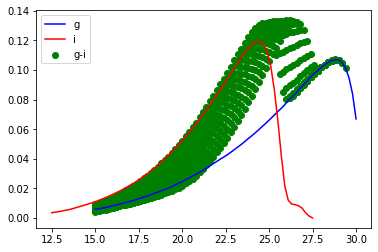

In [3]:
plt.plot(gval,sig_g,c='b', label=filt0)
plt.plot(ival,sig_i,c='r', label=filt1)
pk = ((gvec2-ivec2)>0) & ((gvec2-ivec2)<2)
plt.scatter(gvec2[pk],sig_gi[pk],c='g', label='%s-%s' % (filt0, filt1))
dum = plt.legend()

In [4]:
# try interpolating the grid of sig_gi so that we can draw a locus and
# interpolate over it
from scipy.interpolate import RectBivariateSpline
ff = RectBivariateSpline(gval, ival, sig_gi, kx=5, ky=5)

In [5]:
# let's try drawing a locus of constant color through this
colorIn = 0.5
xFine = np.copy(gval)
yFine = xFine + colorIn
locusLabel = 'locus: %s-%s=%.2f' % (filt0, filt1, colorIn)

# uncomment this to use a near-vertical locus instead
#xFine = np.linspace(24., 25., 50)
#yFine = np.linspace(np.min(ival), np.max(ival), np.size(xFine))
#locusLabel = 'locus: near vertical'

# Chop the arrays down so that we don't go out of the mag-mag space
bOK = (yFine >= np.min(ival)) & (yFine <= np.max(ival))
xFine = xFine[bOK]
yFine = yFine[bOK]

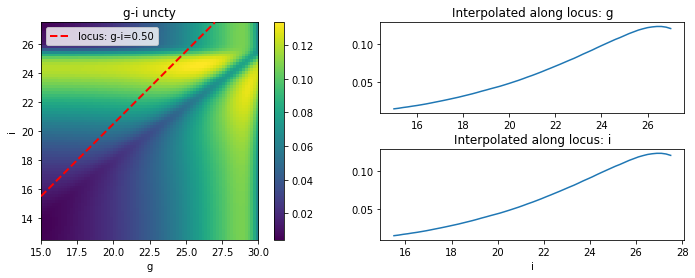

In [6]:
# plt.imshow(sig_gi)
fig3 = plt.figure(3, figsize=(12,4))
ax3 = fig3.add_subplot(121)
dum = ax3.imshow(sig_gi, extent=[np.min(gval), np.max(gval), np.min(ival), np.max(ival)], \
          origin='lower', interpolation='nearest')
ax3.set_xlabel(filt0)
ax3.set_ylabel(filt1)

cb = fig3.colorbar(dum, ax=ax3)

# Show the constant-color locus (watchout - locusLabel defined in the previous cell)
dum2 = ax3.plot(xFine, yFine, 'r--', zorder=5, lw=2, label=locusLabel)
leg2=ax3.legend()

# do the interpolation
zFine = ff.ev(xFine, yFine)

# now show the interpolation
ax3b = fig3.add_subplot(222)
dum3b = ax3b.plot(xFine, zFine)
# ax3b.set_xlabel(filt0)  # label clashes with title below

ax3c = fig3.add_subplot(224)
dum3c = ax3c.plot(yFine, zFine)
ax3c.set_xlabel(filt1)

# set the titles
ax3.set_title('%s-%s uncty' % (filt0, filt1))
ax3b.set_title('Interpolated along locus: %s' % (filt0))
ax3c.set_title('Interpolated along locus: %s' % (filt1))
            

fig3.subplots_adjust(hspace=0.4)


In [7]:
# 2021-12-09 WIC: commenting this out for the moment since it overwrites the definition
# of sig_gi used in the plots above

#sig_g,sig_i,sig_gi = compColorCrowdError(gval, ival, lf12, 1.0, 1.0, singleMag1=np.array([23.,24.,25.]),
#                                         singleMag2=np.array([23.,20.,25.]))
#print(sig_g,sig_i,sig_gi)